# Example 4: Classification

## Regression formulation

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss). 

create the two moon dataset

cpu


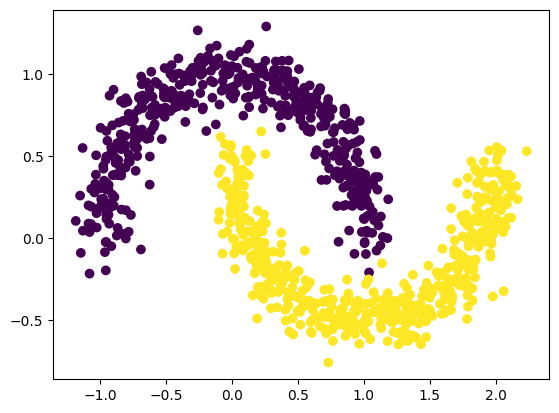

In [1]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

Train KAN

In [2]:
model = KAN(width=[2,1], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 1.55e-01 | reg: 3.91e+00 | : 100%|█| 20/20 [00:01<00:00, 13.48it


saving model version 0.1


(0.9959999918937683, 1.0)

Automatic symbolic regression

In [3]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with sin, r2=0.9688962697982788, c=2
fixing (0,1,0) with x, r2=0.9735038876533508, c=1
saving model version 0.2


-0.8343*x_2 - 0.3821*sin(3.119*x_1 - 1.5518) + 0.7032

How accurate is this formula?

In [4]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.9960)
test acc of the formula: tensor(1.)


## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 2, CrossEntropy loss). 

Create the two moon datatset

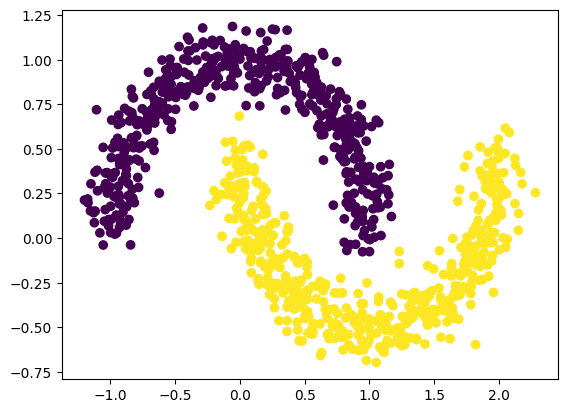

In [5]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

### Train KAN

In [6]:
model = KAN(width=[2,2], grid=3, k=3, seed=2024, device=device)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 0.00e+00 | test_loss: 1.65e-01 | reg: 4.22e+02 | : 100%|█| 20/20 [00:01<00:00, 18.52it

saving model version 0.1


Automatic symbolic regression

In [7]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.518536388874054, c=1
fixing (0,0,1) with x, r2=0.4102415442466736, c=1
fixing (0,1,0) with x, r2=0.9341061115264893, c=1
fixing (0,1,1) with x, r2=0.9358938932418823, c=1
saving model version 0.2


In [8]:
formula1, formula2 = model.symbolic_formula()[0]
ex_round(formula1, 4)

-69.9215*x_1 + 159.8504*x_2 - 26.6287

In [9]:
ex_round(formula2, 4)

47.0891*x_1 - 144.8772*x_2 + 23.2619

How accurate is this formula?

In [10]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.8720)
test acc of the formula: tensor(0.8670)


# Torch class

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [15]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((.5,),(.5,))])
train_dataset = datasets.MNIST(root='./data', 
                               train=True, 
                               download=False, 
                               transform=transform)
test_dataset = datasets.MNIST(root='./data', 
                               train=False, 
                               download=False, 
                               transform=transform)

In [19]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=100,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=100,
                                            shuffle=False)

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activation1(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [23]:
for epoch in range(10):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
    print(f'Epoch {epoch+1}/10, Loss: {running_loss:.4f}')

Epoch 1/10, Loss: 514.4161
Epoch 2/10, Loss: 242.9381
Epoch 3/10, Loss: 208.5448
Epoch 4/10, Loss: 191.4771
Epoch 5/10, Loss: 179.7845
Epoch 6/10, Loss: 169.7485
Epoch 7/10, Loss: 160.7269
Epoch 8/10, Loss: 152.3362
Epoch 9/10, Loss: 144.8717
Epoch 10/10, Loss: 137.7837


In [25]:
correct = 0
total = 0

for images, labels in test_loader:
    images = Variable(images)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print(f'accuracy = {100 * correct / total}%')

accuracy = 93.7699966430664%


# Turn data into a DataFrame

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import pandas as pd

pd_data = pd.DataFrame({'x': X[:, 0],
                       'y': X[:, 1],
                       'label': y})

pd_data.head()

,x,y,label
0,1.154982,0.412296,0
1,1.573996,-0.205313,1
2,0.840897,0.182532,0
3,-0.754372,0.724416,0
4,0.914062,-0.630028,1


In [28]:
# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_layers=10):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_layers)
        self.layer_2 = nn.Linear(in_features=hidden_layers, out_features=hidden_layers)
        self.layer_3 = nn.Linear(in_features=hidden_layers, out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        # return self.layer_3(self.layer_2(self.layer_1(x)))

# Instantiate the model
model = MoonModelV0(input_features=2, output_features=1, hidden_layers=10).to(device)
model


MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [29]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-2)

In [41]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)

# What's coming out of our model?
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

model.eval()
with torch.inference_mode():
    logits = model(X_train).squeeze()

# logits (raw outputs of model)
print("Logits:")
print(logits[:5])

# Prediction probabilities
print("Pred probs:")
pred_probs = torch.sigmoid(logits)
print(pred_probs[:5])

# Prediction labels
print("Pred labels:")
pred_labels = torch.round(pred_probs)
print(pred_labels[:5])
print(y_train[:5])

Logits:
tensor([-0.4160, -0.3378, -0.2985, -0.4013, -0.2951])
Pred probs:
tensor([0.3975, 0.4163, 0.4259, 0.4010, 0.4268])
Pred labels:
tensor([0., 0., 0., 0., 0.])
tensor([0, 1, 1, 0, 1])


In [42]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
#!pip install torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn


MulticlassAccuracy()

In [48]:
np.float_ = np.float64

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs + 1):
    ### Training
    model.train()
    # 1. Forward pass (logits output)
    y_logits = model(X_train).squeeze()
    # Turn logits into prediction probabilities
    pred_probs = torch.sigmoid(y_logits)
    # Turn prediction probabilities into prediction labels
    y_pred = torch.round(pred_probs)
    
    # 2. Calculaute the loss
    loss = loss_fn(y_logits.float(), y_train.float()) # loss = compare model raw outputs to desired model outputs
    
    # Calculate the accuracy
    acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels
    
    # 3. Zero the gradients
    optimizer.zero_grad()
    
    # 4. Loss backward (perform backpropagation)
    loss.backward()
    # 5. Step the optimizer (gradient descent)
    optimizer.step()
    
    ### Testing
    model.eval() 
    with torch.inference_mode():
        # 1. Forward pass (to get the logits)
        y_logits = model(X_test).squeeze()
        # Turn the test logits into prediction labels
        test_pred = torch.round(torch.sigmoid(y_logits))
        
        # 2. Caculate the test loss/acc
        test_loss = loss_fn(test_pred.float(), y_test.float())
        test_acc = acc_fn(test_pred, y_test.int())
        
        # Print out what's happening every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6948 | Acc: 0.48% | Test Loss: 0.6931 | Test Acc: 0.57%
Epoch: 100 | Loss: 0.6786 | Acc: 0.48% | Test Loss: 0.6931 | Test Acc: 0.57%
Epoch: 200 | Loss: 0.6625 | Acc: 0.48% | Test Loss: 0.6931 | Test Acc: 0.57%
Epoch: 300 | Loss: 0.6468 | Acc: 0.70% | Test Loss: 0.6924 | Test Acc: 0.67%
Epoch: 400 | Loss: 0.6282 | Acc: 0.76% | Test Loss: 0.6801 | Test Acc: 0.71%
Epoch: 500 | Loss: 0.6043 | Acc: 0.79% | Test Loss: 0.6744 | Test Acc: 0.73%
Epoch: 600 | Loss: 0.5736 | Acc: 0.79% | Test Loss: 0.6725 | Test Acc: 0.74%
Epoch: 700 | Loss: 0.5364 | Acc: 0.80% | Test Loss: 0.6632 | Test Acc: 0.75%
Epoch: 800 | Loss: 0.4953 | Acc: 0.81% | Test Loss: 0.6582 | Test Acc: 0.76%
Epoch: 900 | Loss: 0.4539 | Acc: 0.82% | Test Loss: 0.6551 | Test Acc: 0.76%
Epoch: 1000 | Loss: 0.4145 | Acc: 0.84% | Test Loss: 0.6470 | Test Acc: 0.78%


In [69]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.turbo, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.plasma)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

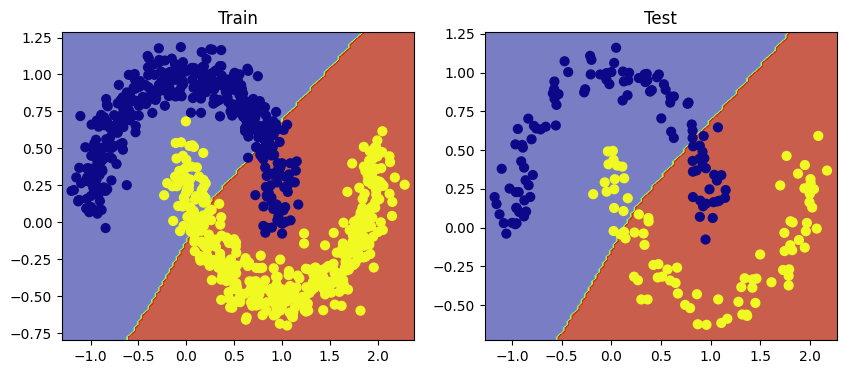

In [70]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)